# Context Confusion: Finding the Right Balance for Production Agents

Context confusion is a **real production problem** affecting agents today.

## The Problem

With MCP making it easy to connect dozens of services, agents can access more tools than ever. But the Berkeley Function-Calling Leaderboard shows a concerning pattern: **every model performs worse when provided with more tools**.

**Context Confusion Definition:** Superfluous content in the context from excessive tools, verbose instructions, or irrelevant information leads to low-quality responses.

The goal is to strike the right balance between capability and clarity. Too few tools limits what your agent can do. Too many tools, or poorly organized context, degrades performance.

## What We'll Explore

In this notebook, we'll use a shipping support agent to:
1. **Identify** how tool bloat, instruction overload, and irrelevant context degrade performance
2. **Measure** the impact using LangSmith evaluations at each problem step
3. **Solve** with three strategies: consolidation, smart routing, and pruning
4. **Validate** improvements LangSmith experiments

The goal: Build agents that are both capable and effective by optimizing what goes into the context.

## Three Problems We'll Solve

Using LangSmith evaluations, we'll diagnose and fix:

**Problem 1: Overloaded tools** - Too many tools degrades quality and model decision making 

**Problem 2: Irrelevant Noise** - Unrelated tools distract the model, even with moderate tool counts

**Problem 3: Instruction Bloat** - Verbose, multi-domain instructions reduce focus and accuracy


## Setup


In [1]:
# Standard library
import os
from typing import List, Dict, Any, Literal
from datetime import datetime

# LangChain & LangSmith
from langchain.agents import create_agent
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langsmith import Client, evaluate
from langsmith.schemas import Run, Example

# Visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from IPython.display import display, HTML

# Environment
from dotenv import load_dotenv
load_dotenv()

# Agent components
from context_confusion.tools import (
    shipping_core_tools,
    carrier_tools, 
    returns_tools,
    warehouse_tools,
    order_modification_tools,
    customer_service_tools,
    billing_tools,
    fraud_tools,
    analytics_tools,
    marketing_tools,
    vendor_tools,
    employee_tools,
    quality_tools,
    all_tools,
)
from context_confusion.instructions import SHIPPING_SUPPORT_INSTRUCTIONS
from context_confusion.additional_context import IRRELEVANT_INSTRUCTIONS

# Evaluators and test data
from context_confusion.tests.evaluators import (
    compare_trajectory,
    trajectory_match_evaluator,
    llm_trajectory_evaluator,
    tool_efficiency_evaluator,
    success_criteria_evaluator,
)
from context_confusion.tests.setup_datasets import create_shipping_dataset
from context_confusion.resources.test_cases import test_cases

# Plotting utilities
from context_confusion.utils.plotting import (
    plot_final_comparison,
    plot_noise_impact,
    plot_routing_comparison,
    plot_instruction_bloat,
)

# Agent utilities
from context_confusion.utils.agent_helpers import (
    run_agent_with_trajectory,
    display_metrics_table,
)

# Initialize LangSmith
client = Client()

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Initialize LLM - using 2025 Haiku for context confusion demo
llm = ChatAnthropic(model="claude-haiku-4-5-20251001", temperature=0)

print(f"Using model: {llm.model}")


Using model: claude-haiku-4-5-20251001


## The Production Agent: Capable but Struggling

Meet our shipping support agent. Over time, we've added tools for every domain:
- Core shipping operations (orders, tracking, shipments)
- Returns and customer service
- Warehouse and inventory management
- Billing and fraud detection
- Analytics and reporting
- Marketing, vendor management, employee ops...

**Total: ~75 tools across 18 domains**

The agent can theoretically handle any shipping-related query. But something's wrong with production performance - context confusion from too many overlapping tool choices.


In [3]:
# Create production agent with all ~75 tools
print("system prompt: ", SHIPPING_SUPPORT_INSTRUCTIONS)

production_agent = create_agent(
    model=llm,
    tools=all_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)


system prompt:  You are a helpful shipping support agent. 
Use the available tools to answer customer questions about orders, tracking, returns, and shipping.

Key guidelines:
- Always verify customer identity before sharing order details if they do not provide their order number
- Check for carrier incidents if there are delivery delays
- Answer what you can based on the tools you have available. 
- If you don't have the information, say so and ask the customer to provide more information, but answer what you can before asking for more information.
- Provide clear, accurate information based on the tools available
- Be concise and answer the customer's question in a few sentences.

Current date: December 22, 2025


## Test Dataset

10 realistic queries covering common shipping support scenarios:


print(f"✓ Loaded {len(test_cases)} test cases")

In [4]:
# Create dataset in LangSmith
dataset_name = "shipping-support-golden"
dataset = create_shipping_dataset(dataset_name, test_cases, client)

print(f"✓ Created dataset with {len(test_cases)} examples")
print(f"   View dataset: https://smith.langchain.com/o/{client._get_tenant_id()}/datasets/{dataset.id}")


✓ Created dataset with 10 examples
   View dataset: https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305


## Define Evaluation Metrics

We'll use four evaluators to measure context confusion impact:


In [5]:
# Evaluators for measuring context confusion impact
ALL_EVALUATORS = [
    trajectory_match_evaluator,      # Flexible trajectory comparison with modes
    success_criteria_evaluator,      # LLM-as-judge for response completeness  
    llm_trajectory_evaluator,        # Recognizes consolidated tool equivalence
    tool_efficiency_evaluator        # Measures call count efficiency
]

print(f"✓ Loaded {len(ALL_EVALUATORS)} evaluators")
print("   - trajectory_match: Flexible comparison with mode support")
print("   - success_criteria: Strict evaluation of response completeness")
print("   - llm_trajectory: Recognizes consolidated tool patterns")
print("   - tool_efficiency: Measures call efficiency")


✓ Loaded 4 evaluators
   - trajectory_match: Flexible comparison with mode support
   - success_criteria: Strict evaluation of response completeness
   - llm_trajectory: Recognizes consolidated tool patterns
   - tool_efficiency: Measures call efficiency


## Agent Wrapper for Structured Output

To enable fair comparisons in our evaluators, we need structured output from the agent:

In [6]:
# Agent wrapper imported from utils
print("✓ Agent wrapper loaded (run_agent_with_trajectory)")


✓ Agent wrapper loaded (run_agent_with_trajectory)


In [7]:
# Extract metrics from LangSmith experiment results
def get_metrics_from_experiment(experiment) -> Dict[str, float]:
    """
    Extract average metrics, latency, and token usage from experiment.
    NO FALLBACKS - gets stats from session.
    """
    results = list(experiment)
    
    metrics = {"trajectory_match": [], "llm_trajectory": [], "success_criteria": [], "tool_efficiency": []}
    
    # Get evaluation scores
    for result in results:
        eval_results = result["evaluation_results"]["results"] 
        for eval_result in eval_results:
            key = eval_result.key  
            if key in metrics and eval_result.score is not None:
                metrics[key].append(eval_result.score)
    
    # Calculate averages
    avg_metrics = {key: sum(values) / len(values) for key, values in metrics.items() if values}
    
    # Get aggregated latency/token stats from session
    session = client.read_project(project_name=experiment.experiment_name, include_stats=True)
    avg_metrics["latency"] = session.latency_p99.total_seconds()
    avg_metrics["tokens"] = session.total_tokens / len(results)
    avg_metrics["cost"] = float(session.total_cost / len(results))
    
    
    return avg_metrics
    
    return avg_metrics

print("✓ Defined get_metrics_from_experiment")


✓ Defined get_metrics_from_experiment


---

## Problem 1: Tool Scaling Degrades Performance

**Hypothesis:** The sheer number of tools is overwhelming the model.

We've seen the production agent struggle. Now let's prove the relationship between tool count and performance.



### Measuring the Problem with LangSmith

Let's evaluate our production agent that has access to 75 tools to see what's actually happening:


In [8]:
# ============================================================================
# EXPERIMENT 1: Current Production (~75 tools) - Context Confusion
# ============================================================================
print(f"\n Running Experiment 1: Production agent with {len(all_tools)} tools...")
print("   Expected: subpar performance due to duplicate tools causing confusion")

production_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(production_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="overload-75-tools",
    metadata={"tool_count": len(all_tools), "config": "production-overload"},
)


 Running Experiment 1: Production agent with 75 tools...
   Expected: subpar performance due to duplicate tools causing confusion
View the evaluation results for experiment: 'overload-75-tools-b0715dd9' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=55e4c108-329c-4227-9901-3e87f1236a42




0it [00:00, ?it/s]

In [9]:
# Fetch metrics from LangSmith Client
production_metrics = get_metrics_from_experiment(production_experiment)

display_metrics_table(
    production_metrics,
    title="Production evaluation complete!",
    note="Context confusion: Too many similar tools lead to poor tool selection"
)


✓ Production evaluation complete!


,Metric,Value
0,Trajectory Match,23.33%
1,Success Criteria,79.00%
2,LLM Trajectory,20.00%
3,Tool Efficiency,0.83
4,Avg Latency,7.07s
5,Avg Tokens,16155
6,Avg Cost,$0.0173



   Context confusion: Too many similar tools lead to poor tool selection


**LangSmith reveals the problem:** Agent calls wrong/duplicate tools (trajectory_match: 27.5%), makes excessive tool calls, and sometimes skips critical tools entirely. With  queries using incorrect tools, context confusion from too many overlapping options is degrading decision-making.

### Lets try reducing number of tools to avoid context confusion

In [10]:
# ============================================================================
# EXPERIMENT 2: Over-Correction (6 specific tools) - Limited Capability
# ============================================================================
print(f"\n🔬 Running Experiment 2: Minimal agent with 6 specific tools...")
print("   Expected: MODERATE performance - efficient but missing capabilities")

minimal_agent = create_agent(
    model=llm,
    tools=shipping_core_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)

minimal_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(minimal_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="minimal-6-tools",
    metadata={"tool_count": 6, "config": "over-correction"},
)

minimal_metrics = get_metrics_from_experiment(minimal_experiment)

display_metrics_table(
    minimal_metrics,
    title="Minimal evaluation complete!",
    note="💡 Overcorrection: Too few tools miss capabilities (returns, carrier incidents, preferences)"
)



🔬 Running Experiment 2: Minimal agent with 6 specific tools...
   Expected: MODERATE performance - efficient but missing capabilities
View the evaluation results for experiment: 'minimal-6-tools-5115c9db' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=db68b965-22a7-4dac-94a8-1242f2129495




0it [00:00, ?it/s]


✓ Minimal evaluation complete!


,Metric,Value
0,Trajectory Match,64.17%
1,Success Criteria,52.00%
2,LLM Trajectory,20.00%
3,Tool Efficiency,0.90
4,Avg Latency,3.89s
5,Avg Tokens,2755
6,Avg Cost,$0.0038



   💡 Overcorrection: Too few tools miss capabilities (returns, carrier incidents, preferences)


**The 6-tool agent is honest but incomplete:** Lacks critical tools (`get_customer_preferences`, `get_return_request`, `get_carrier_incidents`) needed for 6 out of 10 queries. When it has the right tools, it uses them efficiently (trajectory_match: 63.3%), but missing capabilities limit its effectiveness.

---

## Solution 1: Tool Consolidation

**Insight:** Flexible tools with parameters beat many specific tools.

Instead of 75 separate separate tools, create 12 more flexible tools with parameters.


In [11]:
# Import consolidated tools (12 flexible tools with parameters)
from context_confusion.solutions.consolidated_tools import consolidated_tools

print(f"✓ Loaded {len(consolidated_tools)} consolidated tools")
print("  Key consolidations:")
print("  • get_carrier_info: 4 carrier tools → 1 with 'include' parameter")
print("  • manage_order: 4 order actions → 1 with 'action' parameter")
print("  • get_warehouse_info: 3 warehouse tools → 1 with 'include' parameter")


✓ Loaded 12 consolidated tools
  Key consolidations:
  • get_carrier_info: 4 carrier tools → 1 with 'include' parameter
  • manage_order: 4 order actions → 1 with 'action' parameter
  • get_warehouse_info: 3 warehouse tools → 1 with 'include' parameter


In [12]:
# ============================================================================
# EXPERIMENT 3: 12 consolidated tools - Balance of tool number
# ============================================================================

#Remove trajectory match code evaluator because the new tools don't match previous checks. Use llm trajectory for consolidated tools
EVALUATORS_WITHOUT_TRAJECTORY_MATCH = [
    success_criteria_evaluator,
    llm_trajectory_evaluator,
    tool_efficiency_evaluator
]
print(f"\n Running Experiment 3: Optimal agent with 12 consolidated tools...")
print("   Expected: higher performance and lower latency")

optimal_agent = create_agent(
    model=llm,
    tools=consolidated_tools,
    system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
)

optimal_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(optimal_agent, inputs["query"]),
    data=dataset_name,
    evaluators=EVALUATORS_WITHOUT_TRAJECTORY_MATCH,
    experiment_prefix="optimal-12-consolidated",
    metadata={"tool_count": 12, "config": "sweet-spot"},
)

optimal_metrics = get_metrics_from_experiment(optimal_experiment)


display_metrics_table(
    optimal_metrics,
    title="Optimal evaluation complete!",
    note="Consolidated tools with parameters provide clarity and capability!"
)



 Running Experiment 3: Optimal agent with 12 consolidated tools...
   Expected: higher performance and lower latency
View the evaluation results for experiment: 'optimal-12-consolidated-cf26c8ed' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=d1d68621-3c3b-4727-b861-df18f2318074




0it [00:00, ?it/s]


✓ Optimal evaluation complete!


,Metric,Value
0,Success Criteria,90.00%
1,LLM Trajectory,90.00%
2,Tool Efficiency,0.95
3,Avg Latency,6.16s
4,Avg Tokens,7990
5,Avg Cost,$0.0092



   Consolidated tools with parameters provide clarity and capability!


## Final Comparison

The results reveal the most performant balance is with consolidated tools: 


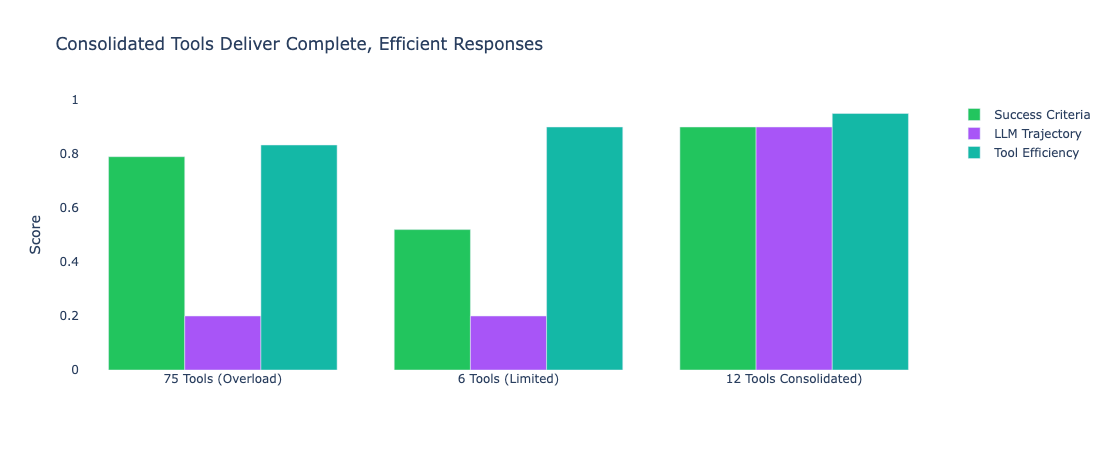

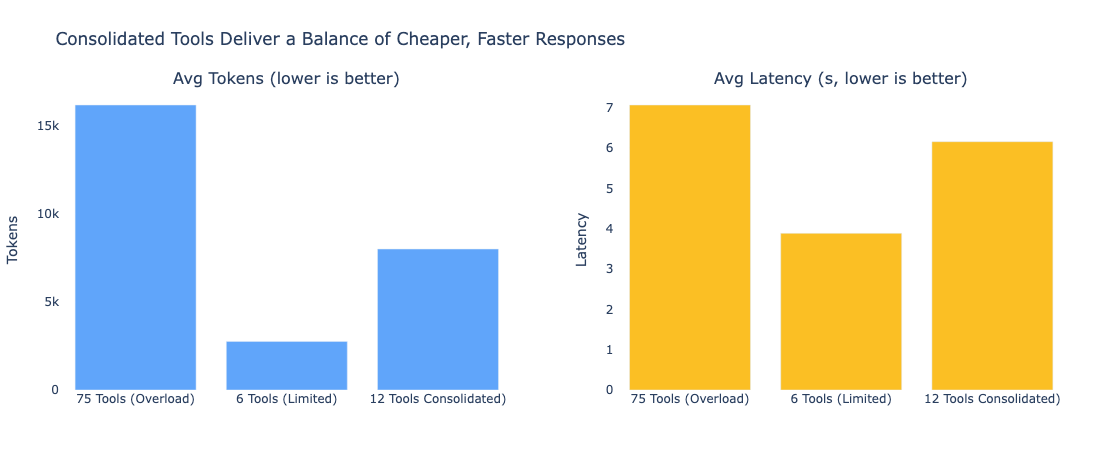

,Configuration,Tool Count,Success Criteria,LLM Trajectory,Tool Efficiency,Avg Latency,Avg Tokens,Avg Cost
0,75 Tools (Overload),75,79.0%,20.0%,0.83,7.07s,16155,$0.0173
1,6 Tools (Limited),6,52.0%,20.0%,0.90,3.89s,2755,$0.0038
2,12 Tools Consolidated),12,90.0%,90.0%,0.95,6.16s,7990,$0.0092



   Key findings: Consolidated tools win across all metrics:
   • Higher success criteria (complete answers)
   • Better tool selection (LLM recognizes appropriate patterns)
   • Improved efficiency (fewer calls, more information)
   • Lower cost: 12-tool agent uses 2.0x fewer tokens than 75-tool agent!


In [13]:
# Plot final comparison across 3 configurations

from context_confusion.utils.plotting import plot_final_comparison

plot_final_comparison(production_metrics, minimal_metrics, optimal_metrics, all_tools)

**LangSmith shows us:** Fewer, focused tools perform better than many scattered tools.


---

## Problem 2: Irrelevant Tools Cause Distraction

**Hypothesis:** It's not just quantity - irrelevant tools also cause context confusion.

Test different ratios of relevant:irrelevant tools (total ~20).


In [14]:
# Create noise ratio configurations

noise_configs = [
    {"name": "100-pct-relevant", "tools": consolidated_tools},
    {"name": "50-pct-relevant", "tools": shipping_core_tools + carrier_tools + fraud_tools + analytics_tools},
    {"name": "25-pct-relevant", "tools": shipping_core_tools + fraud_tools + analytics_tools + marketing_tools + vendor_tools},
]

print("Noise ratio configurations:")
for config in noise_configs:
    print(f"  {config['name']}: {len(config['tools'])} total tools")

# Store experiment results
noise_experiments = {}

# Run experiments
for config in noise_configs:
    print(f"\nTesting {config['name']}...")
    
    agent = create_agent(
        model=llm,
        tools=config["tools"],
        system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
    )
    
    experiment_result = evaluate(
        lambda inputs: run_agent_with_trajectory(agent, inputs["query"]),
        data=dataset_name,
        evaluators=ALL_EVALUATORS,
        experiment_prefix=f"noise-{config['name']}",
        metadata={"config": config["name"]},
    )
    
    noise_experiments[config['name']] = experiment_result
    print(f"  Complete")

print("\nAll noise ratio experiments complete!")

Noise ratio configurations:
  100-pct-relevant: 12 total tools
  50-pct-relevant: 15 total tools
  25-pct-relevant: 18 total tools

Testing 100-pct-relevant...
View the evaluation results for experiment: 'noise-100-pct-relevant-0a833c90' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=7d2ce739-852a-40b6-bdd2-eafeaf5599d1




0it [00:00, ?it/s]

  Complete

Testing 50-pct-relevant...
View the evaluation results for experiment: 'noise-50-pct-relevant-0beebe9a' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=9c515c2e-bd99-47bb-bc32-2cf6f6301a64




0it [00:00, ?it/s]

  Complete

Testing 25-pct-relevant...
View the evaluation results for experiment: 'noise-25-pct-relevant-b14f1544' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=41cd9956-6703-4403-95ac-ba3311cf8cbc




0it [00:00, ?it/s]

  Complete

All noise ratio experiments complete!


### Analyzing the Impact of Irrelevant Tools

Let's extract and visualize the results to see how noise affects performance:


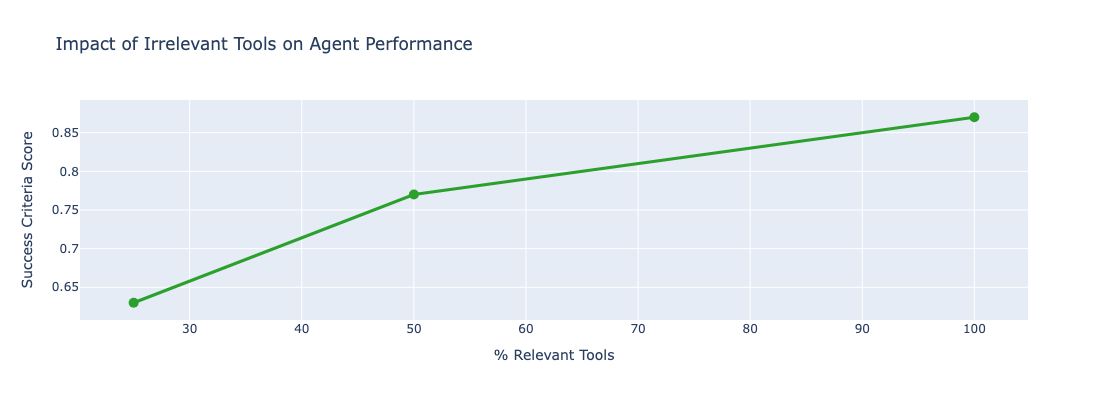

,% Relevant,Success Criteria
0,100,0.87
1,50,0.77
2,25,0.63



Key Findings:
   100% relevant tools: 0.87 success criteria
   25% relevant tools: 0.63 success criteria
   Degradation: 28% drop in success rate
   - Even with constant tool count, noise degrades performance
   - Irrelevant tools lead to incorrect tool calls
   - Quality of tools matters as much as quantity


In [15]:
# Plot noise impact analysis
plot_noise_impact(noise_experiments, get_metrics_from_experiment)

---

## Solution 2: Smart Tool Filtering with Routing

**Insight:** Classify query intent, then provide only relevant tools.


In [16]:
# Simple query router
def classify_query_intent(query: str) -> Literal["shipping", "returns", "billing", "warehouse"]:
    """Classify intent - in production use an LLM."""
    query_lower = query.lower()
    
    if any(word in query_lower for word in ["return", "refund", "send back"]):
        return "returns"
    elif any(word in query_lower for word in ["bill", "charge", "payment"]):
        return "billing"
    elif any(word in query_lower for word in ["stock", "inventory", "warehouse"]):
        return "warehouse"
    else:
        return "shipping"

def get_tools_for_intent(intent: str) -> list:
    """Return tools for intent."""
    if intent == "shipping":
        return consolidated_tools + carrier_tools
    elif intent == "returns":
        return consolidated_tools + returns_tools
    elif intent == "billing":
        return consolidated_tools + billing_tools
    elif intent == "warehouse":
        return consolidated_tools + warehouse_tools
    return consolidated_tools

print("Created intent-based router")

# Test routed agent
def run_routed_agent_with_trajectory(inputs: dict) -> dict:
    """Run routed agent with intent-based tool selection and return structured output."""
    query = inputs["query"]
    intent = classify_query_intent(query)
    tools = get_tools_for_intent(intent)
    
    agent = create_agent(
        model=llm,
        tools=tools,
        system_prompt=SHIPPING_SUPPORT_INSTRUCTIONS
    )
    
    return run_agent_with_trajectory(agent, query)

routed_results = evaluate(
    run_routed_agent_with_trajectory,
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="solution-routed",
    metadata={"config": "routed"},
)

print("\nRouted agent evaluation complete!")


Created intent-based router
View the evaluation results for experiment: 'solution-routed-c05bc249' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=ce82a3f0-119a-428f-bbf2-205292e22db7




0it [00:00, ?it/s]


Routed agent evaluation complete!


### Comparing Routing vs Noise

How does smart routing compare to the worst-case noise scenario?


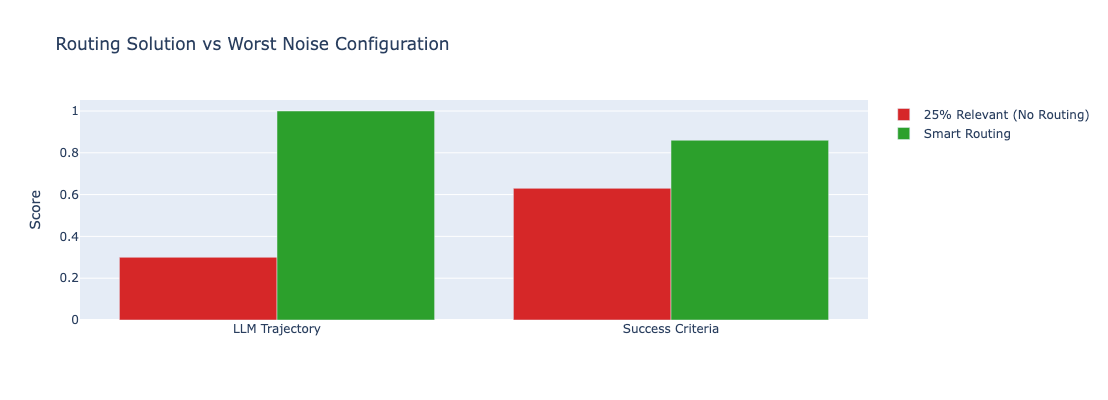

,Configuration,LLM Trajectory,Success Criteria,Tool Efficiency
0,25% Relevant Tools (No Routing),0.3,0.63,0.933333
1,Smart Routing,1.0,0.86,1.000000



Smart routing eliminates noise by classifying query intent and providing only relevant tools, maintaining performance through focused context.


In [17]:
# Plot routing comparison
worst_noise_metrics = get_metrics_from_experiment(noise_experiments["25-pct-relevant"])
routed_metrics = get_metrics_from_experiment(routed_results)

plot_routing_comparison(worst_noise_metrics, routed_metrics)

---

## Problem 3: Instruction Bloat Hurts Too

**Hypothesis:** Verbose instructions degrade performance.

Add evaluator to check instruction following:


In [18]:
# Test with bloated instructions
clean_instructions = SHIPPING_SUPPORT_INSTRUCTIONS
noisy_instructions = SHIPPING_SUPPORT_INSTRUCTIONS + "\n\n" + IRRELEVANT_INSTRUCTIONS

print(f"Clean: {len(clean_instructions):,} chars")
print(f"Noisy: {len(noisy_instructions):,} chars")
print(f"Bloat: {len(noisy_instructions) / len(clean_instructions):.1f}x")

noisy_agent = create_agent(
    model=llm,
    tools=shipping_core_tools,
    system_prompt=noisy_instructions
)

noisy_instruction_experiment = evaluate(
    lambda inputs: run_agent_with_trajectory(noisy_agent, inputs["query"]),
    data=dataset_name,
    evaluators=ALL_EVALUATORS,
    experiment_prefix="problem-noisy-instructions",
    metadata={"tool_count": 6, "instruction_length": len(noisy_instructions)},
)

print("Evaluation complete!")

Clean: 707 chars
Noisy: 15,453 chars
Bloat: 21.9x
View the evaluation results for experiment: 'problem-noisy-instructions-831d7d48' at:
https://smith.langchain.com/o/bcad64b4-50f8-4e66-a0be-8dbaf6f6619c/datasets/18030e35-8fcb-4245-bc01-24aef4d23305/compare?selectedSessions=a4409053-00a0-4ac5-8109-c28fb65a8f3c




0it [00:00, ?it/s]

Evaluation complete!


### Analyzing Instruction Bloat Impact

Let's see how extra instructions affected performance:


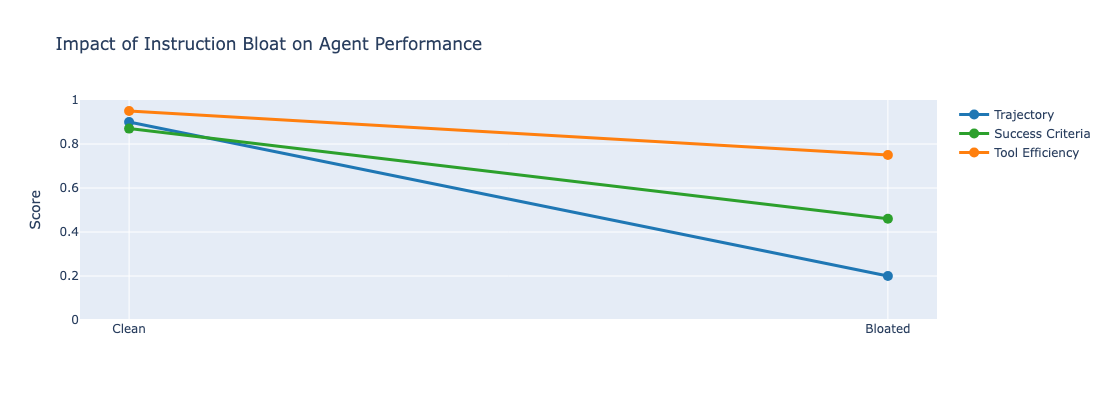

,Metric,Clean Instructions,Bloated Instructions
0,Trajectory,0.90,0.20
1,Success Criteria,0.87,0.46
2,Tool Efficiency,0.95,0.75



Key Findings: Verbose instructions from irrelevant domains degrade trajectory match and success criteria. Focused instructions improve tool selection and agent performance.


In [19]:
# Plot instruction bloat impact
clean_baseline_metrics = get_metrics_from_experiment(noise_experiments["100-pct-relevant"])
bloated_metrics = get_metrics_from_experiment(noisy_instruction_experiment)

plot_instruction_bloat(clean_baseline_metrics, bloated_metrics)

## Key Takeaways

### Context Confusion

Our experiments across 25 shipping support queries demonstrate that:
- **Too many similar tools hurt performance**: 75 overlapping tools lead to poor trajectory match and incomplete responses
- **Tool quality matters as much as quantity**: Even with optimal tool count, irrelevant tools degrade success rates
- **Instruction bloat compounds confusion**: Verbose prompts with irrelevant domain instructions further degrade performance

### Solutions That Work

LangSmith evaluations quantified three effective approaches:

1. **Tool Consolidation**: 12 flexible tools with parameters (e.g., `get_carrier_info(include=["details", "incidents"])`) outperform 75 specific tools
   - Higher trajectory match (agent makes correct choices)
   - Better success criteria (complete, accurate responses)
   - Improved efficiency (fewer redundant calls)

2. **Smart Routing**: Classify query intent to provide only relevant tools
   - Eliminates noise from irrelevant capabilities
   - Maintains performance even with mixed tool sets

3. **Instruction Pruning**: Keep prompts focused and domain-relevant
   - Remove verbose, irrelevant guidance
   - Improves tool selection and response quality

### Implementation Guidance

When building agents with many tools:

1. **Measure first** - Use LangSmith evaluators (trajectory match, LLM assessment, success criteria, efficiency) to establish baselines

2. **Consolidate thoughtfully** - Replace N specific tools with flexible tools using parameters, reducing cognitive load

3. **Filter context** - Use routing or tool selection to provide only relevant capabilities per query

4. **Keep instructions focused** - Prune verbose or irrelevant prompt content

5. **Iterate with evaluations** - Quantify improvements after each change to validate solutions

